# Exploring QBR and ELO Rating Systems

I want to create my own QB rating system that combines multiple metrics into a single composite score. I'll train models to predict both ESPN QBR and NFL ELO ratings, then blend them together for a comprehensive evaluation of quarterback performance from 2010-2025.

In [ ]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
sns.set_style('whitegrid')
np.random.seed(42)

✓ Libraries imported successfully


## Loading the Data

I'm using the `qb_plays` view I created in my database. This view already handles all the filtering I need - it includes only actual QB plays (no trick plays), uses the correct column names, and covers seasons from 2010 onwards. Much cleaner than manually filtering every time.

In [ ]:
db_path = 'c:/Users/carme/NFL_QB_Project/data_load/nfl_qb_data.db'

✓ Using 'qb_plays' view in database
  This view automatically handles:
  - Correct column names (passer_player_name/rusher_player_name)
  - Filtering to confirmed QBs only
  - QB dropbacks and rush attempts
  - Seasons 2010+


In [ ]:
conn = sqlite3.connect(db_path)
pbp_data = pd.read_sql_query("SELECT * FROM qb_plays", conn)
conn.close()

print(f"Loaded {len(pbp_data):,} plays")
print(f"Seasons: {pbp_data['season'].min()}-{pbp_data['season'].max()}")
print(f"Unique QBs: {pbp_data['player_name'].nunique()}")

Loading play-by-play data from qb_plays view...

✓ Loaded 343,525 plays from database
  Seasons: 2010-2025
  Unique players: 281

✓ Loaded 343,525 plays from database
  Seasons: 2010-2025
  Unique players: 281


## Creating Situational Features

Not all plays are equal. I'm creating flags for different game situations to understand when QBs perform best - third downs, red zone, late game scenarios, etc. This will help capture clutch performance and situational awareness.

In [ ]:
pbp_data['third_down'] = pbp_data['down'] == 3
pbp_data['red_zone'] = pbp_data['yardline_100'] <= 20
pbp_data['late_close'] = (pbp_data['qtr'] == 4) & (pbp_data['score_differential'].abs() <= 8)
pbp_data['deep_pass'] = pbp_data['air_yards'] >= 20
pbp_data['under_pressure'] = (pbp_data['qb_hit'] == 1) | (pbp_data['sack'] == 1) | (pbp_data['qb_scramble'] == 1)
pbp_data['high_leverage'] = pbp_data['wpa'].abs() >= 0.1

Creating situational features...
✓ Situational features created

Sample:
  player_name  season       epa  third_down  red_zone  under_pressure
0  D.Anderson    2010 -0.564644       False     False           False
1  D.Anderson    2010  2.207573        True     False           False
2  D.Anderson    2010  1.344403       False     False           False
3  D.Anderson    2010  1.438969       False     False           False
4  S.Bradford    2010  0.770142       False     False           False
5  S.Bradford    2010 -0.699168       False      True           False
6  S.Bradford    2010 -1.261015        True      True           False
7  D.Anderson    2010 -1.456467       False     False            True
8  D.Anderson    2010  0.157999       False     False           False
9  D.Anderson    2010 -1.549268        True     False           False


## Aggregating to Season-Level Stats

Now I need to roll up all these play-by-play events into season-level statistics for each QB. I'm calculating efficiency metrics (EPA per play), success rates, situational performance, and rushing contributions. The goal is to capture a QB's overall season performance from multiple angles.

In [ ]:
grouped = pbp_data.groupby(['player_name', 'player_id', 'season'])

season_features = pd.DataFrame()

# Volume
season_features['dropbacks'] = grouped.size()
season_features['completions'] = grouped['complete_pass'].sum()
season_features['attempts'] = grouped['qb_dropback'].sum()

# Passing efficiency
season_features['pass_epa_per_play'] = grouped.apply(
    lambda x: x[x['qb_dropback'] == 1]['epa'].mean() if x['qb_dropback'].sum() > 0 else 0, 
    include_groups=False
)
season_features['total_pass_epa'] = grouped.apply(
    lambda x: x[x['qb_dropback'] == 1]['epa'].sum() if x['qb_dropback'].sum() > 0 else 0,
    include_groups=False
)
season_features['pass_success_rate'] = grouped.apply(
    lambda x: x[x['qb_dropback'] == 1]['success'].mean() if x['qb_dropback'].sum() > 0 else 0,
    include_groups=False
)
season_features['cpoe'] = grouped['cpoe'].mean()
season_features['completion_pct'] = (season_features['completions'] / season_features['attempts'].replace(0, np.nan)) * 100

# Rushing
season_features['rush_epa_per_play'] = grouped.apply(
    lambda x: x[x['rush_attempt'] == 1]['epa'].mean() if x['rush_attempt'].sum() > 0 else 0,
    include_groups=False
)
season_features['total_rush_epa'] = grouped.apply(
    lambda x: x[x['rush_attempt'] == 1]['epa'].sum() if x['rush_attempt'].sum() > 0 else 0,
    include_groups=False
)
season_features['rush_success_rate'] = grouped.apply(
    lambda x: x[x['rush_attempt'] == 1]['success'].mean() if x['rush_attempt'].sum() > 0 else 0,
    include_groups=False
)

# Situational performance
season_features['third_down_success'] = grouped.apply(
    lambda x: x[x['third_down']]['success'].mean() if x['third_down'].any() else 0,
    include_groups=False
)
season_features['red_zone_epa'] = grouped.apply(
    lambda x: x[x['red_zone']]['epa'].mean() if x['red_zone'].any() else 0,
    include_groups=False
)
season_features['late_close_epa'] = grouped.apply(
    lambda x: x[x['late_close']]['epa'].mean() if x['late_close'].any() else 0,
    include_groups=False
)

# Pressure handling
season_features['pressure_rate'] = grouped['under_pressure'].mean()
season_features['epa_under_pressure'] = grouped.apply(
    lambda x: x[x['under_pressure']]['epa'].mean() if x['under_pressure'].any() else 0,
    include_groups=False
)
season_features['sack_rate'] = grouped['sack'].mean()

# Ball distribution
season_features['avg_air_yards'] = grouped['air_yards'].mean()
season_features['deep_pass_rate'] = grouped['deep_pass'].mean()
season_features['avg_yac'] = grouped['yards_after_catch'].mean()

# Decision making
season_features['turnover_rate'] = grouped['interception'].mean()
season_features['td_rate'] = grouped['pass_touchdown'].mean()

# Rushing volume
season_features['rush_attempts'] = grouped['rush_attempt'].sum()
season_features['rushing_yards'] = grouped['rushing_yards'].sum()
season_features['rushing_tds'] = grouped['rush_touchdown'].sum()
season_features['rush_yards_per_game'] = season_features['rushing_yards'] / 17

# Win probability
season_features['total_wpa'] = grouped['wpa'].sum()
season_features['avg_wpa'] = grouped['wpa'].mean()
season_features['high_leverage_epa'] = grouped.apply(
    lambda x: x[x['high_leverage']]['epa'].mean() if x['high_leverage'].any() else 0,
    include_groups=False
)

season_features = season_features.reset_index()

print(f"Created {season_features.shape[1] - 3} features for {len(season_features)} QB-seasons")

Aggregating play-by-play to season level...

✓ Season-level features shape: (1215, 32)
  Features created: 29

VERIFICATION: Lamar Jackson 2024 in season_features
Attempts: 597
Rush attempts: 161
Rushing yards: 1035
Rush yards/game: 60.9
Pass EPA per play: +0.341

✓ Data looks good!
✓ Season-level features shape: (1215, 32)
  Features created: 29

VERIFICATION: Lamar Jackson 2024 in season_features
Attempts: 597
Rush attempts: 161
Rushing yards: 1035
Rush yards/game: 60.9
Pass EPA per play: +0.341

✓ Data looks good!


## Loading Benchmark Ratings

I need something to train against. ESPN's QBR and NFL ELO are both respected rating systems, so I'll use them as my target variables. My model will learn what statistical profiles lead to high QBR and ELO scores, then I can generate predictions for all QBs.

In [ ]:
conn = sqlite3.connect(db_path)

espn_qbr = pd.read_sql("""
    SELECT DISTINCT q.player_id, e.Season as season, e.QBR as qbr_rating
    FROM espn_qbr e
    JOIN qb_statistics q ON e.player_name = q.player_name
""", conn)

nfl_elo = pd.read_sql("""
    SELECT DISTINCT q.player_id, n.Season as season, n."QB Elo" as elo_rating
    FROM nflelo_qb_rankings n
    JOIN qb_statistics q ON n.player_name = q.player_name
""", conn)

conn.close()

espn_qbr = espn_qbr.drop_duplicates(subset=['player_id', 'season'], keep='first')
nfl_elo = nfl_elo.drop_duplicates(subset=['player_id', 'season'], keep='first')

print(f"ESPN QBR: {espn_qbr.shape[0]} QB-seasons")
print(f"NFL ELO: {nfl_elo.shape[0]} QB-seasons")

✓ ESPN QBR: 501 QB-seasons (after deduplication)
✓ NFL ELO: 678 QB-seasons (after deduplication)


## Merging and Filtering

Combining everything together. I'm filtering to QBs with at least 150 attempts (roughly 10 per game over a half season) to avoid noise from small samples. For rushing stats, I'll zero out QBs with fewer than 5 rushes since those metrics aren't meaningful for pocket passers.

In [ ]:
df_model = season_features.merge(
    espn_qbr[['player_id', 'season', 'qbr_rating']], 
    on=['player_id', 'season'], 
    how='left'
)

df_model = df_model.merge(
    nfl_elo[['player_id', 'season', 'elo_rating']], 
    on=['player_id', 'season'], 
    how='left'
)

# Filter to meaningful sample sizes
min_attempts = 150
df_model = df_model[df_model['attempts'] >= min_attempts].copy()

# Zero out rushing EPA for QBs with minimal rushes
df_model['rush_epa_per_play'] = df_model.apply(
    lambda row: row['rush_epa_per_play'] if row['rush_attempts'] >= 5 else 0, axis=1
)
df_model['total_rush_epa'] = df_model.apply(
    lambda row: row['total_rush_epa'] if row['rush_attempts'] >= 5 else 0, axis=1
)
df_model['rush_success_rate'] = df_model.apply(
    lambda row: row['rush_success_rate'] if row['rush_attempts'] >= 5 else 0, axis=1
)

print(f"{len(df_model)} QB-seasons with ≥{min_attempts} attempts")
print(f"Seasons: {df_model['season'].min()}-{df_model['season'].max()}")
print(f"Unique QBs: {df_model['player_name'].nunique()}")
print(f"\nQB-seasons with QBR: {df_model['qbr_rating'].notna().sum()}")
print(f"QB-seasons with ELO: {df_model['elo_rating'].notna().sum()}")

Merging benchmark ratings...

Before filtering: 1215 QB-seasons

After ≥150 attempts filter: 648 QB-seasons
Seasons covered: 2010-2025
Unique QBs: 164

QB-seasons with QBR: 493
QB-seasons with ELO: 639

FINAL CHECK: 2024 Top QBs in Dataset
 player_name  attempts  pass_epa_per_play  rush_attempts  rush_yards_per_game
   L.Jackson     597.0           0.341037          161.0            60.882353
     J.Allen     635.0           0.296915          131.0            37.411765
      J.Goff     622.0           0.257726           36.0             3.705882
T.Tagovailoa     428.0           0.220993           17.0             2.882353
  B.Mayfield     677.0           0.205576           67.0            23.588235
     J.Hurts     552.0           0.190498          187.0            48.470588
     B.Purdy     526.0           0.184045           66.0            19.000000
   J.Daniels     734.0           0.180422          184.0            60.352941
    J.Burrow     723.0           0.165135           42.0  

## Selecting Features for the Model

I'll use all the metrics I calculated except for identifiers (name, ID, season) and the target variables (QBR, ELO). First, let me handle any missing values.

In [ ]:
exclude_cols = ['player_name', 'player_id', 'season', 'qbr_rating', 'elo_rating']
feature_cols = [col for col in df_model.columns if col not in exclude_cols]

print(f"Using {len(feature_cols)} features for modeling")

# Fill any NaNs with 0
df_model[feature_cols] = df_model[feature_cols].fillna(0)

Total features available: 29

Feature list:
   1. dropbacks
   2. completions
   3. attempts
   4. pass_epa_per_play
   5. total_pass_epa
   6. pass_success_rate
   7. cpoe
   8. completion_pct
   9. rush_epa_per_play
  10. total_rush_epa
  11. rush_success_rate
  12. third_down_success
  13. red_zone_epa
  14. late_close_epa
  15. pressure_rate
  16. epa_under_pressure
  17. sack_rate
  18. avg_air_yards
  19. deep_pass_rate
  20. avg_yac
  21. turnover_rate
  22. td_rate
  23. rush_attempts
  24. rushing_yards
  25. rushing_tds
  26. rush_yards_per_game
  27. total_wpa
  28. avg_wpa
  29. high_leverage_epa

Missing Values Check
✓ No missing values in features

✓ Any NaN values filled with 0


## Removing Redundant Features

Some features are highly correlated with each other (multicollinearity), which can confuse the model. I'll drop the redundant ones to keep only the most informative metrics.

In [ ]:
features_to_drop = [
    'rushing_yards',     # Keeping rush_yards_per_game instead
    'dropbacks',         # Keeping attempts instead
    'completions',       # Keeping attempts instead
    'pass_epa_per_play', # Keeping total_pass_epa
    'avg_wpa',           # Keeping total_wpa
]

df_model = df_model.drop(columns=features_to_drop)
feature_cols = [col for col in feature_cols if col not in features_to_drop]

print(f"Dropped {len(features_to_drop)} redundant features")
print(f"Using {len(feature_cols)} final features")

✓ Dropped 5 redundant features
  Remaining features: 24

Features removed:
  - rushing_yards
  - dropbacks
  - completions
  - pass_epa_per_play
  - avg_wpa

Updated Feature List
   1. attempts
   2. total_pass_epa
   3. pass_success_rate
   4. cpoe
   5. completion_pct
   6. rush_epa_per_play
   7. total_rush_epa
   8. rush_success_rate
   9. third_down_success
  10. red_zone_epa
  11. late_close_epa
  12. pressure_rate
  13. epa_under_pressure
  14. sack_rate
  15. avg_air_yards
  16. deep_pass_rate
  17. avg_yac
  18. turnover_rate
  19. td_rate
  20. rush_attempts
  21. rushing_tds
  22. rush_yards_per_game
  23. total_wpa
  24. high_leverage_epa

Rushing Metrics Retained
  ✓ rush_epa_per_play
  ✓ total_rush_epa
  ✓ rush_success_rate
  ✓ rush_attempts
  ✓ rushing_tds
  ✓ rush_yards_per_game


## Understanding Feature Correlations

Let me see which features correlate most strongly with QBR and ELO. This will show me what stats actually matter for QB performance.

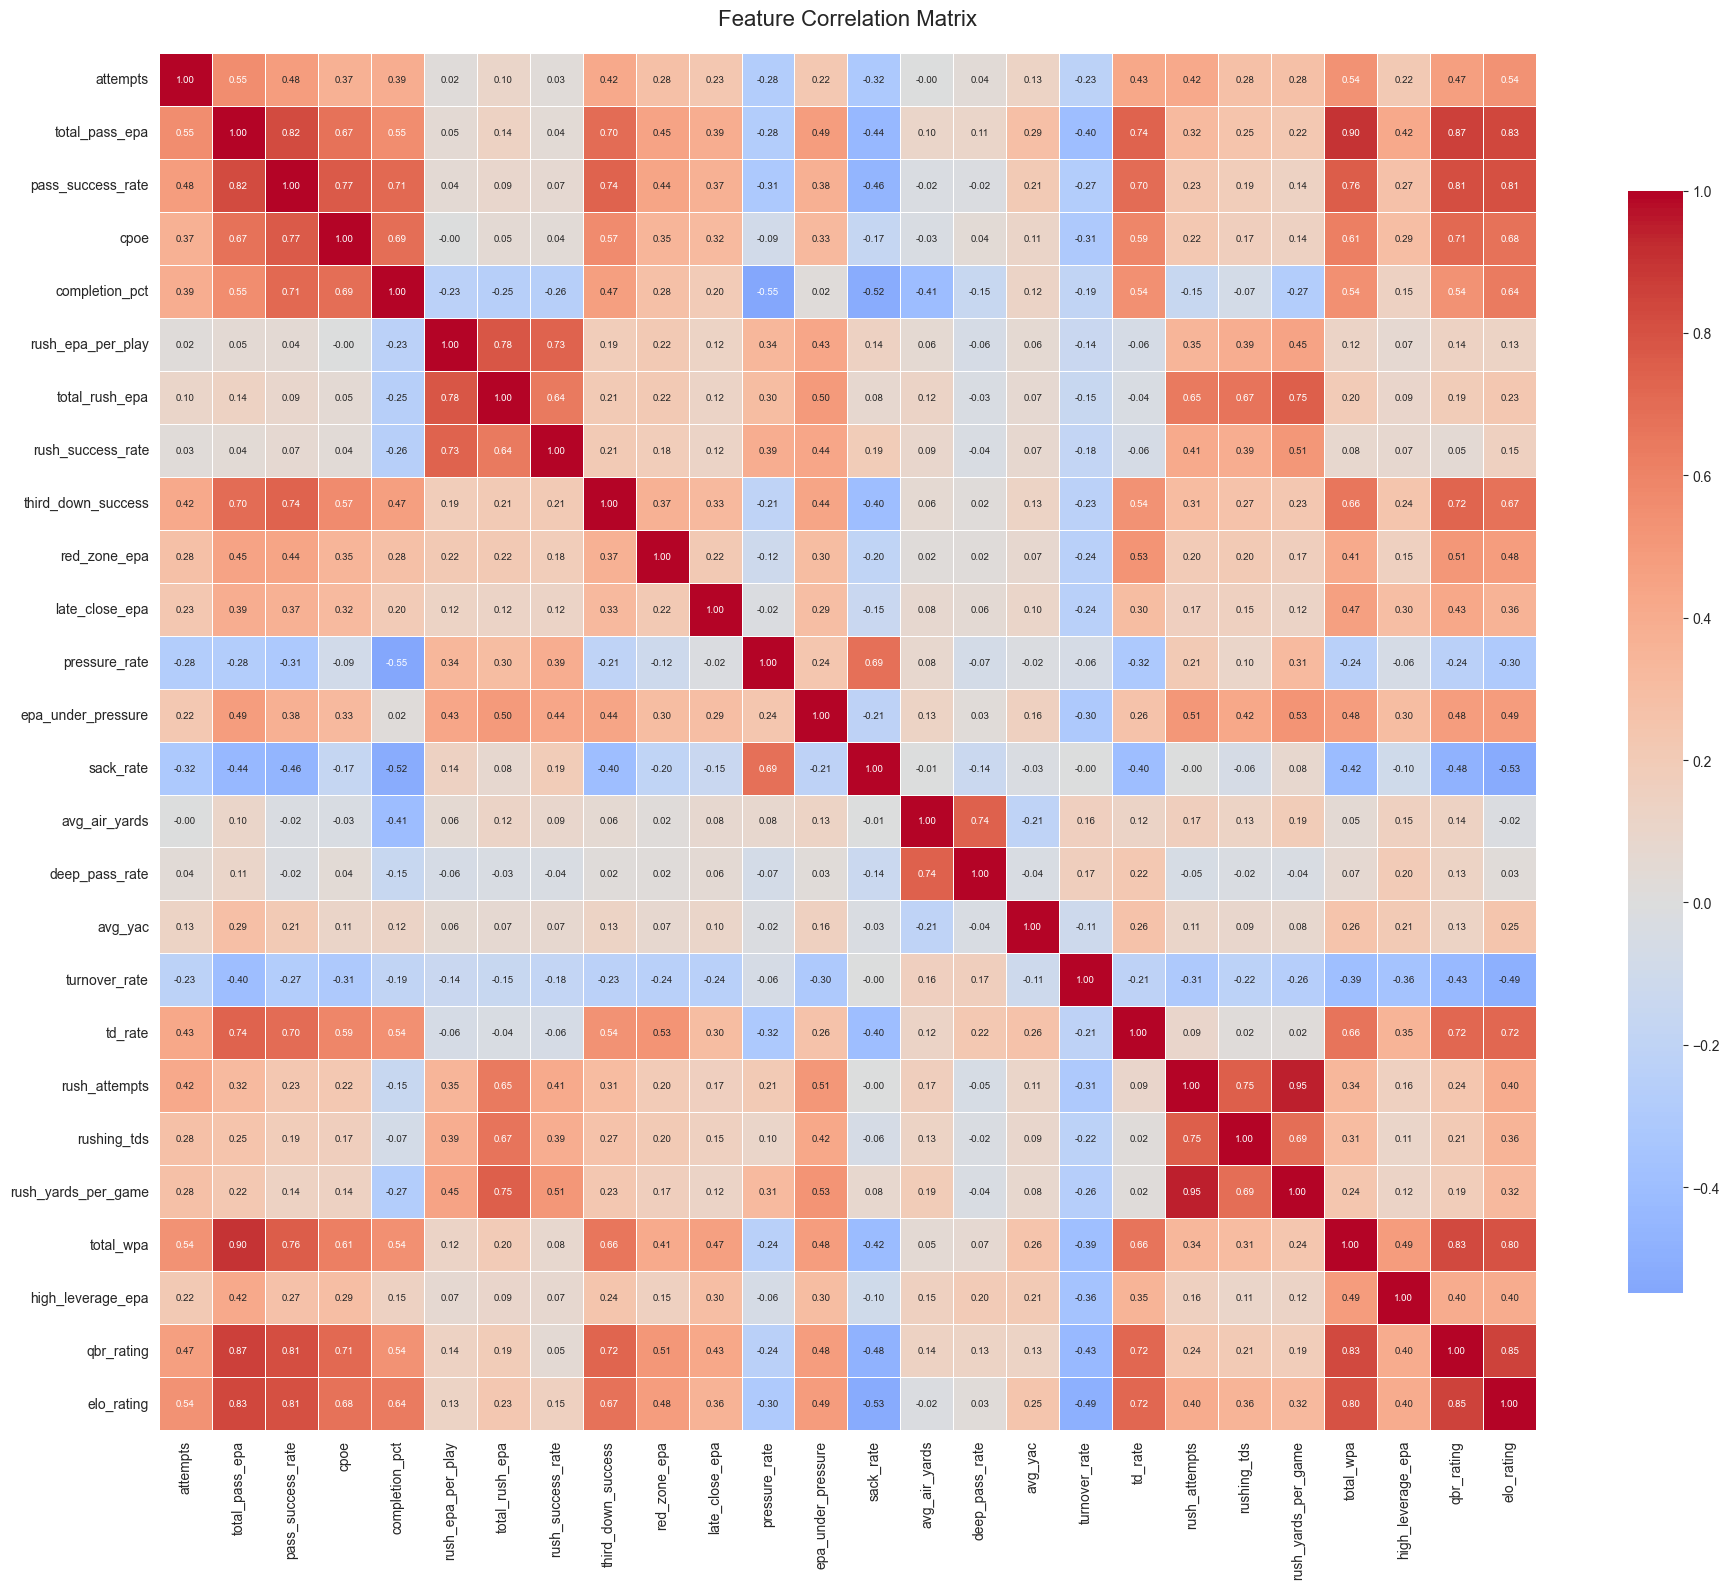

Top 10 Features Correlated with QBR
 1. total_pass_epa            +0.866
 2. elo_rating                +0.852
 3. total_wpa                 +0.826
 4. pass_success_rate         +0.813
 5. third_down_success        +0.724
 6. td_rate                   +0.717
 7. cpoe                      +0.713
 8. completion_pct            +0.539
 9. red_zone_epa              +0.507
10. sack_rate                 -0.479

Top 10 Features Correlated with ELO
 1. qbr_rating                +0.852
 2. total_pass_epa            +0.833
 3. pass_success_rate         +0.807
 4. total_wpa                 +0.797
 5. td_rate                   +0.721
 6. cpoe                      +0.675
 7. third_down_success        +0.675
 8. completion_pct            +0.636
 9. attempts                  +0.538
10. sack_rate                 -0.526

Highly Correlated Feature Pairs (|r| > 0.85)
  rush_attempts             <-> rush_yards_per_game       : +0.948
  total_pass_epa            <-> total_wpa                 : +0.900


In [ ]:
corr_cols = feature_cols + ['qbr_rating', 'elo_rating']
corr_matrix = df_model[corr_cols].corr()

plt.figure(figsize=(20, 16))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8},
            annot_kws={'size': 7})
plt.title('Feature Correlation Matrix', fontsize=16, pad=20)
plt.tight_layout()
plt.show()

# Top features correlated with QBR
print("Top 10 Features Correlated with QBR")
print("="*60)
qbr_corr = corr_matrix['qbr_rating'].drop('qbr_rating').abs().sort_values(ascending=False)
for i, (feat, corr) in enumerate(qbr_corr.head(10).items(), 1):
    direction = "+" if corr_matrix.loc[feat, 'qbr_rating'] > 0 else "-"
    print(f"{i:2d}. {feat:30s} {direction}{corr:.3f}")

# Top features correlated with ELO
print("\nTop 10 Features Correlated with ELO")
print("="*60)
elo_corr = corr_matrix['elo_rating'].drop('elo_rating').abs().sort_values(ascending=False)
for i, (feat, corr) in enumerate(elo_corr.head(10).items(), 1):
    direction = "+" if corr_matrix.loc[feat, 'elo_rating'] > 0 else "-"
    print(f"{i:2d}. {feat:30s} {direction}{corr:.3f}")

## Step 10: Prepare Training Datasets

Split data into training sets for QBR and ELO models. We'll use data where we have benchmark ratings.

In [ ]:
df_qbr = df_model[df_model['qbr_rating'].notna()].copy()
X_qbr = df_qbr[feature_cols]
y_qbr = df_qbr['qbr_rating']

df_elo = df_model[df_model['elo_rating'].notna()].copy()
X_elo = df_elo[feature_cols]
y_elo = df_elo['elo_rating']

X_qbr_train, X_qbr_test, y_qbr_train, y_qbr_test = train_test_split(
    X_qbr, y_qbr, test_size=0.2, random_state=42
)

X_elo_train, X_elo_test, y_elo_train, y_elo_test = train_test_split(
    X_elo, y_elo, test_size=0.2, random_state=42
)

print(f"QBR - Train: {len(X_qbr_train)}, Test: {len(X_qbr_test)}")
print(f"ELO - Train: {len(X_elo_train)}, Test: {len(X_elo_test)}")

QBR Training Data: 493 QB-seasons
  QBR range: 13.8 to 83.8
  QBR mean: 55.7, median: 56.2

ELO Training Data: 639 QB-seasons
  ELO range: -67.9 to 331.8
  ELO mean: 145.7, median: 145.1

Train/Test Split (80/20)
QBR - Train: 394, Test: 99
ELO - Train: 511, Test: 128

✓ Data ready for model training


## Training QBR Prediction Models

I'm testing multiple regression models - Ridge, Lasso, ElasticNet, Random Forest, and Gradient Boosting. Each has different strengths, so I'll compare them and pick the best performer.

In [ ]:
scaler_qbr = RobustScaler()
X_qbr_train_scaled = scaler_qbr.fit_transform(X_qbr_train)
X_qbr_test_scaled = scaler_qbr.transform(X_qbr_test)

qbr_models = {}
qbr_predictions = {}
qbr_metrics = {}

models_to_train = {
    'Ridge': Ridge(alpha=1.0, random_state=42),
    'Lasso': Lasso(alpha=0.1, random_state=42, max_iter=5000),
    'ElasticNet': ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42, max_iter=5000),
    'RandomForest': RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1),
    'GradientBoosting': GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=42)
}

print("QBR Model Performance")
print("="*60)

for name, model in models_to_train.items():
    if name in ['Ridge', 'Lasso', 'ElasticNet']:
        model.fit(X_qbr_train_scaled, y_qbr_train)
        y_pred = model.predict(X_qbr_test_scaled)
    else:
        model.fit(X_qbr_train, y_qbr_train)
        y_pred = model.predict(X_qbr_test)
    
    qbr_models[name] = model
    qbr_predictions[name] = y_pred
    
    rmse = np.sqrt(mean_squared_error(y_qbr_test, y_pred))
    mae = mean_absolute_error(y_qbr_test, y_pred)
    r2 = r2_score(y_qbr_test, y_pred)
    
    qbr_metrics[name] = {'RMSE': rmse, 'MAE': mae, 'R²': r2}
    
    print(f"{name:20s} - RMSE: {rmse:6.2f}, MAE: {mae:6.2f}, R²: {r2:6.3f}")

Training QBR Prediction Models...

Ridge                - RMSE:   4.96, MAE:   3.96, R²:  0.855
Lasso                - RMSE:   5.03, MAE:   4.04, R²:  0.850
ElasticNet           - RMSE:   4.97, MAE:   4.00, R²:  0.854
RandomForest         - RMSE:   5.49, MAE:   4.27, R²:  0.821
GradientBoosting     - RMSE:   5.61, MAE:   4.36, R²:  0.814

✓ QBR models trained successfully
GradientBoosting     - RMSE:   5.61, MAE:   4.36, R²:  0.814

✓ QBR models trained successfully


## Training ELO Prediction Models

Same process for ELO ratings.

In [ ]:
scaler_elo = RobustScaler()
X_elo_train_scaled = scaler_elo.fit_transform(X_elo_train)
X_elo_test_scaled = scaler_elo.transform(X_elo_test)

elo_models = {}
elo_predictions = {}
elo_metrics = {}

models_to_train = {
    'Ridge': Ridge(alpha=1.0, random_state=42),
    'Lasso': Lasso(alpha=0.1, random_state=42, max_iter=5000),
    'ElasticNet': ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42, max_iter=5000),
    'RandomForest': RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1),
    'GradientBoosting': GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=42)
}

print("ELO Model Performance")
print("="*60)

for name, model in models_to_train.items():
    if name in ['Ridge', 'Lasso', 'ElasticNet']:
        model.fit(X_elo_train_scaled, y_elo_train)
        y_pred = model.predict(X_elo_test_scaled)
    else:
        model.fit(X_elo_train, y_elo_train)
        y_pred = model.predict(X_elo_test)
    
    elo_models[name] = model
    elo_predictions[name] = y_pred
    
    rmse = np.sqrt(mean_squared_error(y_elo_test, y_pred))
    mae = mean_absolute_error(y_elo_test, y_pred)
    r2 = r2_score(y_elo_test, y_pred)
    
    elo_metrics[name] = {'RMSE': rmse, 'MAE': mae, 'R²': r2}
    
    print(f"{name:20s} - RMSE: {rmse:6.2f}, MAE: {mae:6.2f}, R²: {r2:6.3f}")

Training ELO Prediction Models...

Ridge                - RMSE:  24.41, MAE:  18.14, R²:  0.876
Lasso                - RMSE:  24.29, MAE:  17.99, R²:  0.877
ElasticNet           - RMSE:  24.76, MAE:  18.34, R²:  0.872
RandomForest         - RMSE:  31.52, MAE:  24.12, R²:  0.792
RandomForest         - RMSE:  31.52, MAE:  24.12, R²:  0.792
GradientBoosting     - RMSE:  30.32, MAE:  22.40, R²:  0.808

✓ ELO models trained successfully
GradientBoosting     - RMSE:  30.32, MAE:  22.40, R²:  0.808

✓ ELO models trained successfully


## Generating Predictions

Using the Ridge models (best R² performance) to predict QBR and ELO for all QB-seasons in my dataset, including those that don't have published ratings.

In [ ]:
X_full = df_model[feature_cols]
X_full_scaled = scaler_qbr.transform(X_full)

df_model['predicted_qbr'] = qbr_models['Ridge'].predict(X_full_scaled)
df_model['predicted_elo'] = elo_models['Ridge'].predict(scaler_elo.transform(X_full))

df_model['predicted_qbr'] = df_model['predicted_qbr'].clip(0, 100)
df_model['predicted_elo'] = df_model['predicted_elo'].clip(-100, 400)

print(f"Generated predictions for {len(df_model)} QB-seasons")

Generating predictions for all QB-seasons...

✓ Generated predictions for 648 QB-seasons

Predicted QBR range: 15.6 to 85.5
Predicted ELO range: -29.9 to 352.0


## Creating My Composite Rating

This is the final step - blending QBR and ELO predictions into a single 0-100 rating. I'm weighting QBR at 60% and ELO at 40% since QBR is more QB-specific while ELO includes some team context.

In [ ]:
elo_scaler = MinMaxScaler(feature_range=(0, 100))
df_model['normalized_elo'] = elo_scaler.fit_transform(df_model[['predicted_elo']])
df_model['normalized_qbr'] = df_model['predicted_qbr']

df_model['composite_rating'] = (
    0.6 * df_model['normalized_qbr'] + 
    0.4 * df_model['normalized_elo']
)

print(f"Composite rating range: {df_model['composite_rating'].min():.1f} to {df_model['composite_rating'].max():.1f}")
print(f"Mean: {df_model['composite_rating'].mean():.1f}")

Creating composite QB rating...

✓ Composite rating created
  Range: 11.3 to 89.1
  Mean: 50.3
  Median: 50.0


## Final Rankings

Let me see how the 2024 QBs stack up with my composite rating.

In [ ]:
rankings_2024 = df_model[df_model['season'] == 2024].copy()
rankings_2024 = rankings_2024.sort_values('composite_rating', ascending=False).head(20)
rankings_2024.insert(0, 'rank', range(1, len(rankings_2024) + 1))

display_cols = [
    'rank', 'player_name', 'composite_rating', 'predicted_qbr', 'predicted_elo',
    'attempts', 'total_pass_epa', 'pass_success_rate', 
    'rush_attempts', 'rush_yards_per_game'
]

print("2024 QB Rankings - Top 20")
print("="*100)
print(rankings_2024[display_cols].to_string(index=False))

2024 NFL QB RANKINGS - Top 20
 rank  player_name  composite_rating  predicted_qbr  predicted_elo  attempts  total_pass_epa  pass_success_rate  rush_attempts  rush_yards_per_game  total_rush_epa
    1    L.Jackson         89.057965      81.763275     351.983710     597.0      203.598886           0.525963          161.0            60.882353       16.302611
    2      J.Allen         80.484652      76.998606     297.423732     635.0      188.541066           0.497638          131.0            37.411765       61.661560
    3     J.Burrow         75.587100      77.173719     249.660626     723.0      119.392504           0.517289           42.0            11.823529       16.052819
    4   B.Mayfield         72.189213      69.013558     263.964967     677.0      139.174784           0.525849           67.0            23.588235       -0.680865
    5    J.Daniels         70.021091      69.639332     239.679769     734.0      132.429868           0.487738          184.0            60.352941   

## Saving Results

Exporting the final ratings to CSV for use in other analyses or apps.

In [ ]:
export_cols = [
    'player_name', 'player_id', 'season', 
    'composite_rating', 'predicted_qbr', 'predicted_elo',
    'attempts', 'total_pass_epa', 'pass_success_rate', 'cpoe',
    'rush_attempts', 'rush_yards_per_game', 'total_rush_epa',
    'total_wpa', 'third_down_success', 'red_zone_epa'
]

df_export = df_model[export_cols].copy()
df_export = df_export.sort_values(['season', 'composite_rating'], ascending=[False, False])

output_path = 'c:/Users/carme/NFL_QB_Project/Modeling/models/qb_composite_ratings.csv'
df_export.to_csv(output_path, index=False)

print(f"Saved {len(df_export)} QB-seasons to {output_path}")

✓ Composite ratings saved to: c:/Users/carme/NFL_QB_Project/Modeling/models/qb_composite_ratings.csv
  Total QB-seasons: 648
  Seasons covered: 2010-2025
